# Particle filters in action
This Jupyter notebook provides the code accompanying the example in Section 4.5. in [1].
The example is based on the model employed in [2].

This notebook was written by Anna Kutschireiter (anna.kutschireiter@gmail.com) and any feedback is highly appreciated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import poisson
# plt.rcParams.update({'font.size': 18})
import matplotlib as mpl
mpl.rc('text', usetex = True)
font = {'family' : 'DejaVu Sans',
        'size'   : 22}
mpl.rc('font', **font)

## Nonlinear filtering with Gaussian noise
Here, we consider a model 
### Data generation

In [2]:
np.random.seed(42)

# Simulation parameters
T = 5
dt = 0.001 # s
t = np.arange(0,T,dt)

# model parameters
f = lambda x: -4*x*(x**2-1) # hidden drift function
F = lambda x: 4-12*x # Jacobian of hidden drift function
sigx = np.sqrt(2) # hidden diffusion constant
h = lambda x: x  # observation function
H = lambda x: 1 # Jacobian of observation function
sigy = np.sqrt(0.1)

X = np.zeros(int(T/dt)) # hidden state, starts at 0
dy = np.zeros(int(T/dt)) 
dy[0] = np.random.normal(h(X[0])*dt,sigy*np.sqrt(dt)) 
for i in range(1,int(T/dt)):
    # state transition
    X[i] = X[i-1] + f(X[i-1])*dt + sigx*np.random.normal(0,1) * np.sqrt(dt)
    dy[i] = np.random.normal(h(X[i])*dt,sigy*np.sqrt(dt))

### Extended Kalman-Bucy filter

In [3]:
def EKBF(mu,var,dy,f,F,h,H,sigx,sigy,dt):
    
    dmu = f(mu)*dt + var * H(mu) * sigy**(-2) * (dy - h(mu)*dt)
    dvar = (2*H(mu)*var + sigx**2 - var**2 * H(mu)**2 *sigy**(-2))*dt

    mu_out = mu + dmu
    var_out = var + dvar
    
    return mu_out, var_out

In [4]:
mu_EKBF = np.zeros(int(T/dt))
mu_EKBF[0] = 0
var_EKBF = np.zeros(int(T/dt))
var_EKBF[0] = 1

for i in range(1,int(T/dt)):
    mu_EKBF[i],var_EKBF[i] = EKBF(mu_EKBF[i-1],var_EKBF[i-1],dy[i],f,F,h,H,sigx,sigy,dt)

### Bootstrap particle filter

In [5]:
def ParticleFilter(x,w,dy,f,sigx,h,sigy,dt,alpha=0):
    
    N = len(x)
    
    # particle diffusion
    x_out = x + f(x)*dt + sigx*np.random.normal(0,1,N) * np.sqrt(dt)
    
    # compute weights
    w_out = w * norm.pdf(dy, h(x)*dt, sigy*np.sqrt(dt)) 
    w_out = w_out/np.sum(w_out) # weight normalization
    
    #resampling
    if alpha != 0:
        Neff = 1/( np.sum(w_out**2) ) # effective number of particles
        if Neff/N <= alpha:
            x_out = np.random.choice(x_out,N,p=w_out)
            w_out = 1/N*np.ones(N)
    
    return x_out,w_out

In [6]:
N = 1000
alpha = 0.2

x_PF = np.zeros([int(T/dt),N])
x_PF[0] = np.random.normal(0,1,N)
w_PF = np.zeros([int(T/dt),N])
w_PF[0] = 1/N

for i in range(1,int(T/dt)):
    # state transition
    x_PF[i],w_PF[i] = ParticleFilter(x_PF[i-1],w_PF[i-1],dy[i],f,sigx,h,sigy,dt,alpha)

### Feedback particle filter

In [7]:
def FeedbackPF(x,dy,f,sigx,h,sigy,dt,alpha=0):
    
    N = len(x)
    
    # constant gain approximation
    h_bar = np.average(h(x))
    K = np.average(x*(h(x)-h_bar))
    
    # particle diffusion with correction term
    x_out = x + f(x)*dt + K*sigy**(-2)*(dy - (h(x)+h_bar)/2*dt ) + sigx*np.random.normal(0,1,N) * np.sqrt(dt)
    
    return x_out

In [8]:
N = 1000
alpha = 0.2

x_FPF = np.zeros([int(T/dt),N])
x_FPF[0] = np.random.normal(0,1,N)

for i in range(1,int(T/dt)):
    # state transition
    x_FPF[i] = FeedbackPF(x_FPF[i-1],dy[i],f,sigx,h,sigy,dt,alpha)

### Plots

In [9]:
def histImage(x, bins, rang, w=0):
    image = np.zeros((x.shape[0],bins))
    
    if np.isscalar(w):
        for i in range(x.shape[0]):
            image[i,:] = np.histogram(x[i,:],bins,rang,density=True)[0]
    else:
        for i in range(x.shape[0]):
            image[i,:] = np.histogram(x[i,:],bins,rang,weights=w[i,:],density=True)[0]
        
    return image

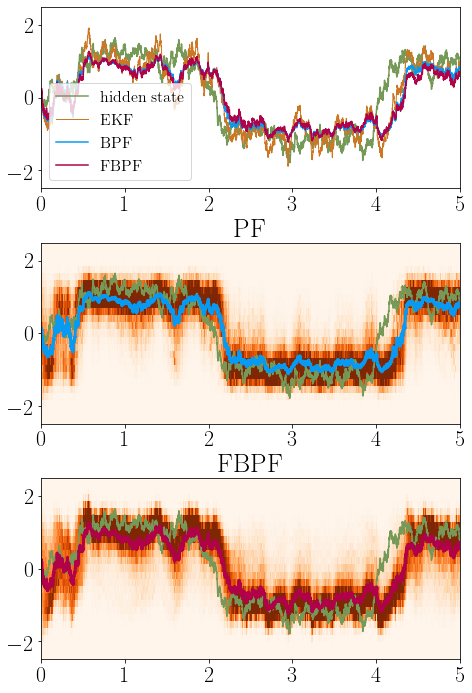

In [25]:
plotrange = [0,T,-2.5,2.5]

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(7.5,12))
ax1.plot(t,X,color = 'xkcd:moss')
ax1.plot(t,mu_EKBF,color = 'xkcd:brownish orange',linewidth=1)
ax1.plot(t,np.average(x_PF,1,w_PF),color = 'xkcd:azure')
ax1.plot(t,np.average(x_FPF,1,None),color = 'xkcd:raspberry')
ax1.axis(plotrange)
ax1.legend(['hidden state','EKF','BPF','FBPF'],fontsize=16)

hist = np.transpose(histImage(x_PF,int(np.sqrt(N)),(-3,3),w=w_PF))
ax2.imshow(np.flipud(hist), cmap='Oranges', interpolation='nearest', extent=[0,T,-3,3],aspect='auto',vmax=0.7)
ax2.plot(t,X,color='xkcd:moss')
ax2.plot(t,np.average(x_PF,1,w_PF), linewidth=3,color = 'xkcd:azure')
ax2.axis(plotrange)
ax2.set_title('PF')

hist = np.transpose(histImage(x_FPF,int(np.sqrt(N)),(-3,3)))
ax3.imshow(np.flipud(hist), cmap='Oranges', interpolation='nearest', extent=[0,T,-3,3],aspect='auto',vmax=0.7)
ax3.plot(t,X,color='xkcd:moss')
ax3.plot(t,np.average(x_FPF,1), linewidth=3,color = 'xkcd:raspberry')
ax3.axis(plotrange)
ax3.set_title('FBPF')

plt.subplots_adjust(hspace=0.3)
plt.savefig('63 - particle filters - gauss.pdf')

plt.show()

## Nonlinear filtering with Poisson noise

In [11]:
np.random.seed(42)

# model parameters
sigx = np.sqrt(2) # hidden diffusion constant
g0 = 50
s0 = 0.05
m0 = np.array([-1,1])
g =  lambda x: g0 * np.transpose(np.exp( - np.array([x-m0[0],x-m0[1]])**2/(2 * s0**2) ))  # observation function

# X = np.zeros(int(T/dt)) # hidden state, starts at 0
dN = np.zeros((int(T/dt),2)) 
dN[0] = np.random.poisson(g(X[0])*dt)
for i in range(1,int(T/dt)):
    # state transition
#     X[i] = X[i-1] + f(X[i-1])*dt + sigx*np.random.normal(0,1) * np.sqrt(dt)
    dN[i] = np.random.poisson(g(X[i])*dt)

### Bootstrap particle filter

In [12]:
def ParticleFilter_PP(x,w,dN,f,sigx,g,dt,alpha=0):
    
    N = len(x)
    
    # particle diffusion
    x_out = x + f(x)*dt + sigx*np.random.normal(0,1,N) * np.sqrt(dt)
    # compute weights
    w_out = w * np.prod(poisson.pmf(dN, g(x)*dt),1)
    w_out = w_out/np.sum(w_out) # weight normalization
    
    #resampling
    if alpha != 0:
        Neff = 1/( np.sum(w_out**2) ) # effective number of particles
        if Neff/N <= alpha:
            x_out = np.random.choice(x_out,N,p=w_out)
            w_out = 1/N*np.ones(N)
    
    return x_out,w_out

In [13]:
N = 1000
alpha = 0.2

x_PF_PP = np.zeros([int(T/dt),N])
x_PF_PP[0] = np.random.normal(0,1,N)
w_PF_PP = np.zeros([int(T/dt),N])
w_PF_PP[0] = 1/N

for i in range(1,int(T/dt)):
    # state transition
    x_PF_PP[i],w_PF_PP[i] = ParticleFilter_PP(x_PF_PP[i-1],w_PF_PP[i-1],dN[i],f,sigx,g,dt,alpha)

### Plots

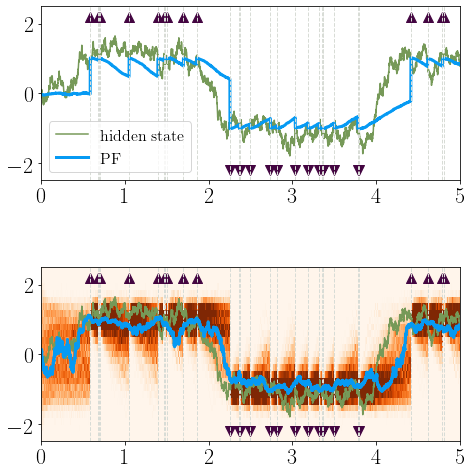

In [26]:
t_minus = np.where(dN[:,0]>=1)[0]
t_plus = np.where(dN[:,1]>=1)[0]

plotrange = [0, T, -2.5, 2.5]

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7.5,8))
plt.subplots_adjust(hspace=0.5)

ax1.plot(t,X,color = 'xkcd:moss')
ax1.plot(t,np.average(x_PF_PP,1,w_PF_PP),color = 'xkcd:azure',linewidth=3)
for spikepos in t[np.where(dN>=1)[0]]:
    ax1.axvline(x=spikepos,linestyle='--',color = 'xkcd:light grey',linewidth=1)
ax1.scatter(t[t_plus],2.2*np.ones(t_plus.size),marker="^",c='xkcd:eggplant purple',s=100)
ax1.scatter(t[t_minus],-2.2*np.ones(t_minus.size),marker="v",c='xkcd:eggplant purple',s=100)
ax1.axis(plotrange)
ax1.legend(['hidden state','PF'],fontsize=16)

hist = np.transpose(histImage(x_PF_PP,int(np.sqrt(N)),(-3,3),w=w_PF_PP))
ax2.imshow(np.flipud(hist), cmap='Oranges', interpolation='nearest', extent=[0,T,-3,3],aspect='auto',vmax=0.7)
for spikepos in t[np.where(dN>=1)[0]]:
    ax2.axvline(x=spikepos,linestyle='--',color = 'xkcd:light grey',linewidth=1)
ax2.scatter(t[t_plus],2.2*np.ones(t_plus.size),marker="^",c='xkcd:eggplant purple',s=100)
ax2.scatter(t[t_minus],-2.2*np.ones(t_minus.size),marker="v",c='xkcd:eggplant purple',s=100)
ax2.plot(t,X,color='xkcd:moss')
ax2.plot(t,np.average(x_PF,1,w_PF), linewidth=3,color = 'xkcd:azure')
ax2.axis(plotrange)

plt.savefig('63 - particle filters - Poisson.pdf')

plt.show()

## References
[1] Kutschireiter, A., Surace, S. C., & Pfister, J.-P. (2019). The Hitchhikers Guide to Nonlinear Filtering. ArXiv, 1–42. Retrieved from http://arxiv.org/abs/1903.09247